# Train Models to Recognize Kitharai
*Adapted from the [Keras Applications](https://keras.io/api/applications/) page and [Image Classification Tutorial](https://www.tensorflow.org/tutorials/images/classification).*

In [1]:
# import libraries from tensorflow keras (for model building), sklearn (for metrics), matplotlib (for visualization), and np/os/pd (for data processing)
import tensorflow as tf
from tensorflow.keras import optimizers, losses, activations, models, applications, layers, metrics
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [2]:
# set display options
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### Set up the training / testing datasets

In [3]:
# create absolute path to location of images
data_dir = os.path.dirname(os.getcwd()) + '\\data\\images-model\\inceptionv3\\'

# create alternate absolute paths for a pre-split training / testing dataset
data_dir_train = os.path.dirname(os.getcwd()) + '\\data\\images-model\\train\\'
data_dir_test = os.path.dirname(os.getcwd()) + '\\data\\images-model\\test\\'

# show the paths created
# print(data_dir)
# print(data_dir_train)
# print(data_dir_test)

In [4]:
# set variables for the model here
# number of images per batch
batch_size = 32

# all images have been resized to 558x558 pixels, the median size of a kithara in the dataset
img_height = 558
img_width = 558

In [5]:
# # create a training and testing dataset from the pre-processed images
# # this code generates the train/test split within the image_dataset_from_directory call
# train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#   data_dir,
#   validation_split=0.25,
#   subset="training",
#   seed=42,
#   image_size=(img_height, img_width),
#   batch_size=batch_size,
#   label_mode = 'categorical')

# # create a testing dataset from the pre-processed images
# val_ds = tf.keras.preprocessing.image_dataset_from_directory(
#   data_dir,
#   validation_split=0.25,
#   subset="validation",
#   seed=42,
#   image_size=(img_height, img_width),
#   batch_size=batch_size,
#   label_mode = 'categorical')

In [6]:
# create a training and testing dataset from the pre-processed images
# this code uses the train/test split already specified in notebook 02
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode = 'categorical')

# create a testing dataset from the pre-processed images
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode = 'categorical')

Found 4057 files belonging to 2 classes.
Found 1353 files belonging to 2 classes.


In [7]:
# create a variable to store the filepaths for the files in the val_ds dataframe
# we'll need this later to align the image IDs with the predictions
filepaths = val_ds.file_paths
# check the filepaths list created
# filepaths

In [67]:
# # DO NOT USE THIS TO GET THE ACTUAL KITHARA / NO-KITHARA LABELS FOR THE IMAGES
# # STILL NEED TO DETERMINE WHY THE ARRAY CHANGES ORDER EVERY TIME IT IS RUN
val_labels = [np.argmax(y.numpy(), axis = -1) for _, y in val_ds]
print(val_labels)
val_labels = np.concatenate(val_labels)
print(val_labels)
print(len(val_labels))

[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 1], dtype=int64), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64), array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0], dtype=int64), array([1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1], dtype=int64), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64), array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64), array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1], dtype=int64),

In [9]:
# based on the file name recorded in the filepaths variable, create a list of actual kithara / no-kithara labels for the images
extracted_values = [int('no-kithara' in f) for f in filepaths]

# check the list created
# print(extracted_values)

In [10]:
# xheck that the class names are as anticipated
class_names = train_ds.class_names
print(class_names)

['kithara', 'no-kithara']


In [11]:
# check the batch shapes in the training dataset
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 558, 558, 3)
(32, 2)


*Note that the following cell is intended to improve the performance of the model and overall memory / CPU usage, in line with the [Keras Performance Recommendations](https://www.tensorflow.org/datasets/performances).*

In [12]:
# use prefetch to optimize run time
# use tf.data.autotune to automatically adjust the buffer size
AUTOTUNE = tf.data.AUTOTUNE

# make the training data easier to process
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
# normalize the 0 to 255 values in the color images to between 0 and 1
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [14]:
# create a normalized training dataset
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.3254902 0.5568628


In [15]:
# create a normalized testing dataset
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_val_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.4039216 0.6


### Build a base model from the inceptionv3 model architecture

In [16]:
# create the base pre-trained model
# note that if this does not run, downgrade h5py
# pip install "h5py==2.10.0" --force-reinstall
base_model = applications.InceptionV3(weights = 'imagenet',
                                      include_top=False,
                                      input_shape = (img_height, img_width, 3))

### Add customizations to the base model for model01

In [59]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and add a logistic layer -- output should be the number of classes (in this case, 2)
predictions01 = Dense(2, activation='softmax')(x)

In [60]:
# this is the model we will train
model01 = Model(inputs=base_model.input, outputs=predictions01)

In [61]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

In [62]:
# compile the model (should be done *after* setting layers to non-trainable)
model01.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics = ['BinaryAccuracy',
                        'FalseNegatives',
                        'FalsePositives',
                        'TrueNegatives',
                        'TruePositives',
                        'AUC',
                        'Precision',
                        'Recall'])

### Fit model01 on the normalized training data

In [63]:
# set the number of passes over the entire dataset as the number of epochs
epochs = 10

# fit the model based on the normalized training data
# write the comparative metrics on the normalized training and testing data to history
history01 = model01.fit(
  normalized_ds,
  validation_data = normalized_val_ds,
  epochs=epochs
)

Epoch 1/10
127/127 [==============================] - 1301s 10s/step - loss: 0.1891 - binary_accuracy: 0.9199 - false_negatives: 325.0000 - false_positives: 325.0000 - true_negatives: 3732.0000 - true_positives: 3732.0000 - auc: 0.9782 - precision: 0.9199 - recall: 0.9199 - val_loss: 0.0994 - val_binary_accuracy: 0.9616 - val_false_negatives: 52.0000 - val_false_positives: 52.0000 - val_true_negatives: 1301.0000 - val_true_positives: 1301.0000 - val_auc: 0.9939 - val_precision: 0.9616 - val_recall: 0.9616
Epoch 2/10
127/127 [==============================] - 1274s 10s/step - loss: 0.1207 - binary_accuracy: 0.9502 - false_negatives: 202.0000 - false_positives: 202.0000 - true_negatives: 3855.0000 - true_positives: 3855.0000 - auc: 0.9870 - precision: 0.9502 - recall: 0.9502 - val_loss: 0.1136 - val_binary_accuracy: 0.9557 - val_false_negatives: 60.0000 - val_false_positives: 60.0000 - val_true_negatives: 1293.0000 - val_true_positives: 1293.0000 - val_auc: 0.9861 - val_precision: 0.9557

### Predict the probability that an image contains a kithara based on model01

In [64]:
# predict the probability of kithara / no-kithara label of the normalized_val_ds images
# N.B. COMMENT OUT THIS CELL ONCE IT HAS BEEN RUN TO PREVENT ACCIDENTALLY RE-RUNNING IT
test_predictions01 = model01.predict(normalized_val_ds)

In [65]:
# check the min/max probabilities of predicted kithara / no-kithara labels
print(test_predictions01.min(axis = 0))
print(test_predictions01.max(axis = 0))

# print the names of the classes for clarity
print(class_names)

# return the array of predictions
print(test_predictions01)

[8.6093063e-22 1.0236905e-06]
[0.9999989 1.       ]
['kithara', 'no-kithara']
[[6.26443503e-15 1.00000000e+00]
 [8.02905728e-11 1.00000000e+00]
 [1.63888356e-14 1.00000000e+00]
 ...
 [1.33343939e-15 1.00000000e+00]
 [1.01064375e-08 1.00000000e+00]
 [1.93719760e-17 1.00000000e+00]]


In [66]:
# convert the probabilities into a binary class prediction
# adjust the threshold as needed to optimize for precision / recall
# N.B. the threshold is set based on probability of a `no-kithara` label
predicted_class01 = (test_predictions01[:,1]>=0.5).astype(int)
print(predicted_class01)

[1 1 1 ... 1 1 1]


### Model01 performance analysis
*Performance analysis for model01, a 10-epoch inceptionv3 instance with two additional layers trained on images that have only been normalized to 0-1 as opposed to 0-255 per pixel value.*

In [68]:
# take a look at the metrics from each epoch
history01.history

{'loss': [0.18910625576972961,
  0.12069103121757507,
  0.09559719264507294,
  0.09108439832925797,
  0.08861461281776428,
  0.07763504981994629,
  0.06892059743404388,
  0.06594407558441162,
  0.05618894845247269,
  0.05260312557220459],
 'binary_accuracy': [0.9198915362358093,
  0.9502094984054565,
  0.9585900902748108,
  0.96376633644104,
  0.9632733464241028,
  0.9679566025733948,
  0.9696820378303528,
  0.9743652939796448,
  0.9765836596488953,
  0.9792950749397278],
 'false_negatives': [325.0,
  202.0,
  168.0,
  147.0,
  149.0,
  130.0,
  123.0,
  104.0,
  95.0,
  84.0],
 'false_positives': [325.0,
  202.0,
  168.0,
  147.0,
  149.0,
  130.0,
  123.0,
  104.0,
  95.0,
  84.0],
 'true_negatives': [3732.0,
  3855.0,
  3889.0,
  3910.0,
  3908.0,
  3927.0,
  3934.0,
  3953.0,
  3962.0,
  3973.0],
 'true_positives': [3732.0,
  3855.0,
  3889.0,
  3910.0,
  3908.0,
  3927.0,
  3934.0,
  3953.0,
  3962.0,
  3973.0],
 'auc': [0.9782100319862366,
  0.9869801998138428,
  0.99069166183471

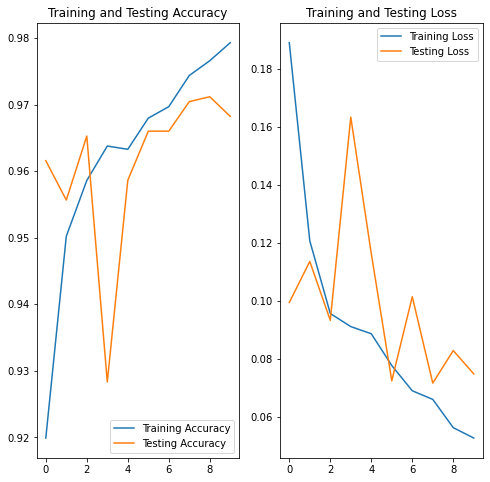

In [69]:
# visualize the model's performance epoch-by-epoch

# set accuracy variables
acc = history01.history['binary_accuracy']
val_acc = history01.history['val_binary_accuracy']

# set loss variables
loss = history01.history['loss']
val_loss = history01.history['val_loss']

# set epoch range
epochs_range = range(epochs)

# plot accuracy for training vs. testing dataset
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Testing Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Testing Accuracy')

# plot loss for training vs. testing dataset
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Testing Loss')
plt.legend(loc='upper right')
plt.title('Training and Testing Loss')
plt.show()

In [70]:
# print the accuracy of the kithara identification compared to the predicted class with the threshold set above
print(accuracy_score(val_labels, predicted_class01))

# print the AUC for the model
print(roc_auc_score(val_labels, test_predictions01[:,1]))

# print the overall classification report with precision, recall, accuracy, and f1-scores
print(classification_report(val_labels, predicted_class01, target_names = class_names))

0.9682187730968219
0.9901825242718447
              precision    recall  f1-score   support

     kithara       0.76      0.84      0.80       103
  no-kithara       0.99      0.98      0.98      1250

    accuracy                           0.97      1353
   macro avg       0.88      0.91      0.89      1353
weighted avg       0.97      0.97      0.97      1353



In [ ]:
# create a dataframe to hold the filenames, actual values, and predicted no-kithara probability
pred_df01 = pd.DataFrame({'filepath': filepaths, 'actuals': extracted_values, 'predictions': test_predictions01[:,0]})

# take a look at the dataframe where the known value was a kithara
pred_df01[pred_df01['actuals'] == 0].sort_values('predictions')

In [ ]:
# # check to see if specific images are included in the training dataset
# pred_df01[pred_df01['filepath'].str.contains('IMAG9081')]

### Iterate over the first model: add transformations of the training data using `ImageDataGenerator`

In [21]:
# create an image data generator for the training and testing images
train_datagen = image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = image.ImageDataGenerator(rescale=1./255)

In [22]:
# create a training and testing dataset from the pre-processed images
# this code uses the train/test split already specified in notebook 02
train_gen = train_datagen.flow_from_directory(
    data_dir_train,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True,
    seed = 42)

# create a testing dataset from the pre-processed images
val_gen = test_datagen.flow_from_directory(
    data_dir_test,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False,
    seed = 42)

Found 4057 images belonging to 2 classes.
Found 1353 images belonging to 2 classes.


In [23]:
# set the number of passes over the entire dataset as the number of epochs
epochs = 2

# fit the first model based on the normalized training data
# write the comparative metrics on the normalized training and testing data to history
history02 = model01.fit(
  train_gen,
  validation_data = val_gen,
  epochs=epochs
)

Epoch 1/2
127/127 [==============================] - 1436s 11s/step - loss: 0.1943 - binary_accuracy: 0.9270 - false_negatives: 296.0000 - false_positives: 296.0000 - true_negatives: 3761.0000 - true_positives: 3761.0000 - auc: 0.9741 - val_loss: 0.2920 - val_binary_accuracy: 0.8426 - val_false_negatives: 213.0000 - val_false_positives: 213.0000 - val_true_negatives: 1140.0000 - val_true_positives: 1140.0000 - val_auc: 0.9477
Epoch 2/2
127/127 [==============================] - 1420s 11s/step - loss: 0.1273 - binary_accuracy: 0.9453 - false_negatives: 222.0000 - false_positives: 222.0000 - true_negatives: 3835.0000 - true_positives: 3835.0000 - auc: 0.9846 - val_loss: 0.1062 - val_binary_accuracy: 0.9549 - val_false_negatives: 61.0000 - val_false_positives: 61.0000 - val_true_negatives: 1292.0000 - val_true_positives: 1292.0000 - val_auc: 0.9886


### Predict the probability that an image contains a kithara based on model01 with extra image data generated in the training dataset

In [24]:
# predict the probability of kithara / no-kithara label of the normalized_val_ds images
# N.B. COMMENT OUT THIS CELL ONCE IT HAS BEEN RUN TO PREVENT ACCIDENTALLY RE-RUNNING IT
test_predictions02 = model01.predict(val_gen)

In [25]:
# check the min/max probabilities of predicted kithara / no-kithara labels
print(test_predictions02.min(axis = 0))
print(test_predictions02.max(axis = 0))

# print the names of the classes for clarity
print(class_names)

# return the array of predictions
print(test_predictions02)

[6.3764532e-14 1.5814198e-02]
[0.98418576 1.        ]
['kithara', 'no-kithara']
[[5.4795191e-02 9.4520485e-01]
 [8.5919011e-01 1.4080985e-01]
 [3.0525232e-04 9.9969482e-01]
 ...
 [1.3031657e-09 1.0000000e+00]
 [1.2477184e-09 1.0000000e+00]
 [1.8510232e-10 1.0000000e+00]]


In [32]:
# convert the probabilities into a binary class prediction
# adjust the threshold as needed to optimize for precision / recall
# N.B. the threshold is set based on probability of a `no-kithara` label
predicted_class02 = (test_predictions02[:,1]>=0.99).astype(int)
print(predicted_class02)

[0 0 1 ... 1 1 1]


### Model01 with extra image data generated performance analysis
*Performance analysis for model01, a 10-epoch inceptionv3 instance with two additional layers, trained on images that have been normalized to 0-1 as opposed to 0-255 per pixel value **and** have additional images generated from them.*

In [33]:
# take a look at the metrics from each epoch
history02.history

{'loss': [0.19433674216270447, 0.1272713989019394],
 'binary_accuracy': [0.9270396828651428, 0.9452797770500183],
 'false_negatives': [296.0, 222.0],
 'false_positives': [296.0, 222.0],
 'true_negatives': [3761.0, 3835.0],
 'true_positives': [3761.0, 3835.0],
 'auc': [0.9740806221961975, 0.9846477508544922],
 'val_loss': [0.29204463958740234, 0.10624955594539642],
 'val_binary_accuracy': [0.842572033405304, 0.9549149870872498],
 'val_false_negatives': [213.0, 61.0],
 'val_false_positives': [213.0, 61.0],
 'val_true_negatives': [1140.0, 1292.0],
 'val_true_positives': [1140.0, 1292.0],
 'val_auc': [0.9477266669273376, 0.9886176586151123]}

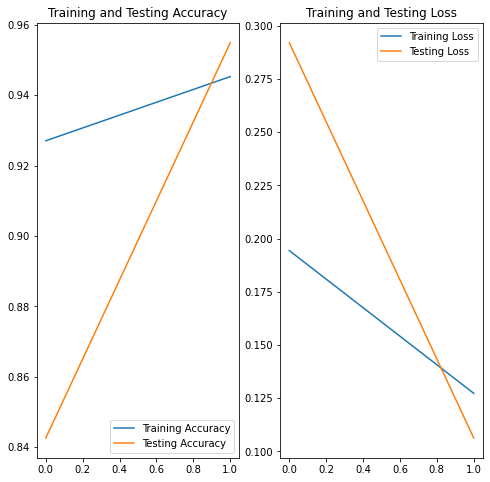

In [34]:
# visualize the model's performance epoch-by-epoch

# set accuracy variables
acc = history02.history['binary_accuracy']
val_acc = history02.history['val_binary_accuracy']

# set loss variables
loss = history02.history['loss']
val_loss = history02.history['val_loss']

# set epoch range
epochs_range = range(epochs)

# plot accuracy for training vs. testing dataset
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Testing Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Testing Accuracy')

# plot loss for training vs. testing dataset
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Testing Loss')
plt.legend(loc='upper right')
plt.title('Training and Testing Loss')
plt.show()

In [37]:
# print the accuracy of the kithara identification compared to the predicted class with the threshold set above
print(accuracy_score(extracted_values, predicted_class02))

# print the AUC for the model
print(roc_auc_score(extracted_values, test_predictions02[:,1]))

# print the overall classification report with precision, recall, accuracy, and f1-scores
print(classification_report(extracted_values, predicted_class02, target_names = class_names))

0.8470066518847007
0.5513553398058253
              precision    recall  f1-score   support

     kithara       0.11      0.14      0.12       103
  no-kithara       0.93      0.91      0.92      1250

    accuracy                           0.85      1353
   macro avg       0.52      0.52      0.52      1353
weighted avg       0.86      0.85      0.86      1353



In [49]:
test_labels = []
test_images = []
for images, labels in val_ds.take(len(val_ds)):
    test_labels += [x for x in labels.numpy()]
    test_images += [x for x in images.numpy()]
pred_test = model02.predict(np.stack(test_images))
# plot_auc(test_labels, pred_test, 'Test')
# plot_predictions(test_labels, pred_test, 'Test')

In [52]:
print(roc_auc_score(test_labels, pred_test))

0.371768932038835


In [58]:
test_labels

[array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([1.

In [53]:
predicted_class03 = (pred_test[:,1]>=0.99).astype(int)

In [57]:
print(classification_report(test_labels[:,1], predicted_class03, target_names = class_names))

TypeError: list indices must be integers or slices, not tuple

In [36]:
# create a dataframe to hold the filenames, actual values, and predicted no-kithara probability
pred_df02 = pd.DataFrame({'filepath': filepaths, 'actuals': extracted_values, 'predictions': test_predictions02[:,0]})

# take a look at the dataframe where the known value was a kithara
pred_df02[pred_df02['actuals'] == 0].sort_values('predictions')

,filepath,actuals,predictions
950,C:\Users\Veronica\Documents\2020-21_NSS-DS-Bootcamp\ds4-cv-vases\data\images-model\test\kithara\IMAG2104a-kithara-full.jpg,0,5.041992e-12
663,C:\Users\Veronica\Documents\2020-21_NSS-DS-Bootcamp\ds4-cv-vases\data\images-model\test\kithara\IMAG0034-kithara-full.jpg,0,8.597190e-12
1066,C:\Users\Veronica\Documents\2020-21_NSS-DS-Bootcamp\ds4-cv-vases\data\images-model\test\kithara\IMAG9870a-kithara-full.jpg,0,1.081128e-11
506,C:\Users\Veronica\Documents\2020-21_NSS-DS-Bootcamp\ds4-cv-vases\data\images-model\test\kithara\IMAG9215-kithara-full.jpg,0,1.127631e-11
858,C:\Users\Veronica\Documents\2020-21_NSS-DS-Bootcamp\ds4-cv-vases\data\images-model\test\kithara\IMAG0353b-kithara-full.jpg,0,1.188923e-11
933,C:\Users\Veronica\Documents\2020-21_NSS-DS-Bootcamp\ds4-cv-vases\data\images-model\test\kithara\IMAG9949-kithara-full.jpg,0,1.349073e-11
1044,C:\Users\Veronica\Documents\2020-21_NSS-DS-Bootcamp\ds4-cv-vases\data\images-model\test\kithara\IMAG1542-kithara-full.jpg,0,1.832079e-11
118,C:\Users\Veronica\Documents\2020-21_NSS-DS-Bootcamp\ds4-cv-vases\data\images-model\test\kithara\IMAG0294-kithara-full.jpg,0,2.299521e-11
1340,C:\Users\Veronica\Documents\2020-21_NSS-DS-Bootcamp\ds4-cv-vases\data\images-model\test\kithara\IMAG5980-kithara-full.jpg,0,2.629704e-11
664,C:\Users\Veronica\Documents\2020-21_NSS-DS-Bootcamp\ds4-cv-vases\data\images-model\test\kithara\IMAG9824-kithara-full.jpg,0,2.742352e-11


In [ ]:
# # check to see if specific images are included in the training dataset
# pred_df01[pred_df01['filepath'].str.contains('IMAG9081')]

### Try a model with fewer neurons

In [42]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# add a couple of fully-connected layers
x = Dense(500, activation='relu')(x)
x = Dense(100, activation='relu')(x)
# and add a logistic layer -- output should be the number of classes (in this case, 2)
predictions02 = Dense(2, activation='softmax')(x)

In [43]:
# this is the model we will train
model02 = Model(inputs=base_model.input, outputs=predictions02)

In [44]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

In [45]:
# compile the model (should be done *after* setting layers to non-trainable)
model02.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics = ['BinaryAccuracy',
                        'FalseNegatives',
                        'FalsePositives',
                        'TrueNegatives',
                        'TruePositives',
                        'AUC'])

In [47]:
# set the number of passes over the entire dataset as the number of epochs
epochs = 2

# fit the second model based on the normalized training data with extra image data generated
# write the comparative metrics on the normalized training and testing data to history
history03 = model02.fit(
  train_gen,
  validation_data = val_gen,
  epochs=epochs
)

Epoch 1/2
 57/127 [============>.................] - ETA: 9:43 - loss: 0.2269 - binary_accuracy: 0.9095 - false_negatives: 165.0000 - false_positives: 165.0000 - true_negatives: 1659.0000 - true_positives: 1659.0000 - auc: 0.9666

KeyboardInterrupt: 

In [ ]:
# look at the inceptionv3 layer names and layer indices to see how many layers the base model has
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

In [ ]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

In [ ]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')